In [ ]:
import pandas as pd
from thesis.utils.class_utils import create_data_module, get_label_mapper
from thesis.configs.config_reader import load_config
import viz_unified as viz
config = load_config("../configs/config.yml")

In [2]:
dm_trainval, dm_test = create_data_module(config, False, stage="fit"), create_data_module(config, True, stage="test")  # mixture_setup is called inside
lm = get_label_mapper(config)
name_fn = lambda s: lm.get_classname_by_idx(int(s["labels_idx"])).lower()

synth = viz.SyntheticDatasetSource(dm_trainval.raw_synthetic, name_fn=name_fn)
real_df = pd.read_parquet(
    f"../data/measurements/{config['DATA']['REAL_MEASUREMENT_DIR']}/{config['DATA']['SYNTHETIC_DATASET_NAME']}/dataframe.parquet",
    engine="pyarrow",
)
real = viz.RealParquetSource(real_df, spec_col="spectrum", name_col="name_cleaned", alias_map=lm.alias_map)

2025-09-30 16:00:24 - INFO - Setting up datasets for stage: fit...
2025-09-30 16:00:24 - INFO - Positive class indices specified: [1, 3, 2]
2025-09-30 16:00:25 - INFO - Positive class indices specified: [1, 3, 2]
2025-09-30 16:00:26 - INFO - ===TRAIN===
2025-09-30 16:00:26 - INFO - Pure: 1052  Mixed: 10520  Total: 11572
2025-09-30 16:00:26 - INFO - ===VAL===
2025-09-30 16:00:26 - INFO - Pure: 500  Mixed: 5000  Total: 5500
2025-09-30 16:00:26 - INFO - Data modules setup complete.
2025-09-30 16:00:26 - INFO - Setting up datasets for stage: test...
2025-09-30 16:00:26 - INFO - Setting up test dataset...


Test dataset kwargs: {'x_col': 'xSample', 'y_col': 'ySample', 'spectra_col': 'spectrum', 'name_col': 'name_cleaned', 'sample_path': '../data\\measurements\\AMICS Data Part1\\ds_500minerals\\dataframe.parquet', 'image_path': '../data\\measurements\\AMICS Data Part1\\combined_image.npy', 'transforms': OrderedTransformPipeline(required_pre=[SamplePreparation(), Smoothing(sigma=1.0), BaselineCorrection(kernel_size=51)], optional_transforms=[], required_post=[NormIT(), NormSqrt(), FinalConversion(use_soft_labels=True, num_classes=501)], min_optionals=0, max_optionals=0)}


Accessible keys in raw sample: ['spectra', 'labels', 'labels_idx', 'compositions', 'file_names', 'serials', 'ch_abs', 'ch_lin', 'filter_id', 't_life', 'tube_current', 'voltage', 'spectrum_type', 'rel_temp', 'rel_pres', 'pu_2ph', 'pu_3ph']
SamplePreparation: t_life=0.1, tube_current=0.6, total_counts_per_second=None, is_real_data=False
Applied KCPS scaling: 429429.4685379613 kcps, total_counts=42942.94685379614. T_life=0.1
AddNoise: T_LIFE changed from 0.1000s to 0.0662s
SamplePreparation: t_life=0.061, tube_current=0.6, total_counts_per_second=127786.8852, is_real_data=True
Accessible keys in raw sample: ['spectra', 'labels', 'labels_idx', 'compositions', 'file_names', 'serials', 'ch_abs', 'ch_lin', 'filter_id', 't_life', 'tube_current', 'voltage', 'spectrum_type', 'rel_temp', 'rel_pres', 'pu_2ph', 'pu_3ph']
SamplePreparation: t_life=0.1, tube_current=0.6, total_counts_per_second=None, is_real_data=False
Applied KCPS scaling: 394697.42019074655 kcps, total_counts=39469.742019074656. T_

<Axes: title={'center': 'Albite — Synthetic vs Real'}, xlabel='Energy (keV)', ylabel='Intensity'>

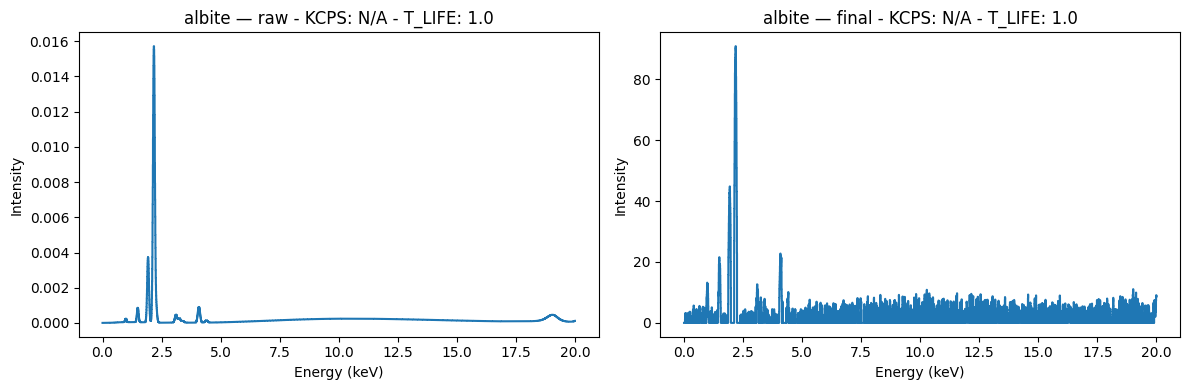

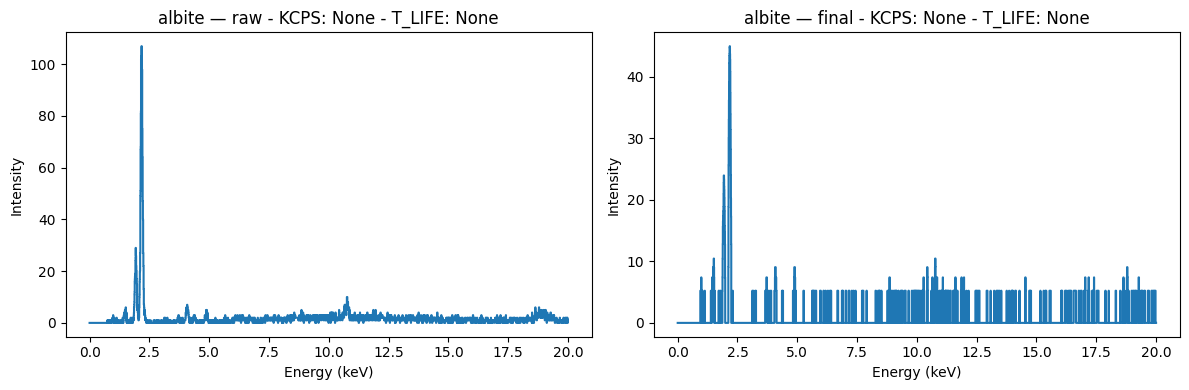

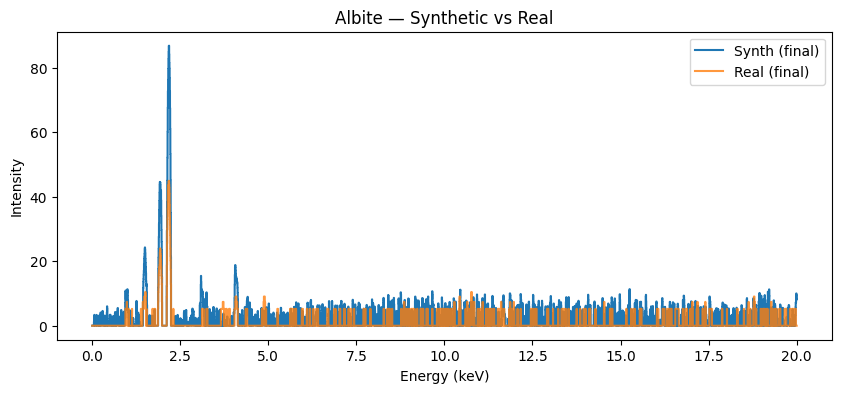

In [ ]:
# can plot with sources synth (synthetically generated) or real (from AMICS export)
# These are the transforms in order (note that for real/test/validation, augmentation steps (a) are not applied, only preprocessing (p) and VST (v) steps):
# - SamplePreparation (-),
# - AddPileup (a), AddKCPS (a), AddNoise (a), Shift (a), Gain (a),
# - Smoothing (p), BaselineCorrection (p),
# - NormIT (v), NormSqrt/LogTransform/Anscombe (v), FinalConversion (-)
# plot_single(synth, "Albite", pipeline=dm.train_pipeline, stage="final", logy=False)
# synth.get_by_index(78)
# print(synth.get_by_index("Ferri"))
viz.plot_pre_post(
    synth,
    "Albite",
    pipeline=dm_trainval.train_pipeline,
    before="AddKCPS",
    after="AddNoise",
    is_real=False, # ! CHECK if this should be False or True!
    logy=False,
)
viz.plot_pre_post(
    real,
    "Albite",
    pipeline=dm_trainval.val_pipeline,
    before="raw",
    after="final",
    is_real=True, # ! CHECK if this should be False or True!
    logy=False,
)
# viz.plot_pre_post(
#     real,
#     "Albite",
#     pipeline=dm.real_pipeline,
#     before="raw",
#     after="final",
#     is_real=True,
#     logy=False,
# )
viz.plot_comparison(
    "Albite",
    synth,
    real,
    dm_trainval.train_pipeline,
    dm_test.real_pipeline,
    synth_stage="final",
    real_stage="final",
    normalize=False,
    logy=False,
)